<a href="https://colab.research.google.com/github/datafilik/mobile-nextgen-wireless-comms-rsrch/blob/master/FullMimoOfdmSystemSimV1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
Created on Mon Oct 17 22:43:09 2022
@Title: Mutliuser MIMO OFDM simualtions
@author: voche
"""

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

from sionna.mimo import StreamManagement

from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer
from sionna.ofdm import OFDMModulator, OFDMDemodulator, ZFPrecoder, RemoveNulledSubcarriers

from sionna.channel.tr38901 import Antenna, AntennaArray, CDL, UMi, UMa, RMa
from sionna.channel import gen_single_sector_topology as gen_topology
from sionna.channel import subcarrier_frequencies, cir_to_ofdm_channel, cir_to_time_channel
from sionna.channel import ApplyOFDMChannel, ApplyTimeChannel, OFDMChannel

from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder

from sionna.mapping import Mapper, Demapper

from sionna.utils import BinarySource, ebnodb2no, sim_ber, QAMSource
from sionna.utils.metrics import compute_ber

# We need to enable sionna.config.xla_compat before we can use
# tf.function with jit_compile=True.
# See https://nvlabs.github.io/sionna/api/config.html#sionna.Config.xla_compat
sionna.config.xla_compat=True


# SYSTEM KERAS MODEL FOR BER SIMULATIONS
class MimoOfdmSystemModel(tf.keras.Model):
    """Simulate OFDM MIMO transmissions over a 3GPP 38.901 model.
    """
    def __init__(self, scenario, perfect_csi, speed):
        super().__init__()

        # Provided parameters
        self._scenario = scenario
        self._perfect_csi = perfect_csi
        self._speed = speed

        # Internally set parameters
        self._carrier_frequency = 28e9 #3.5e9
        self._fft_size = 128
        self._subcarrier_spacing = 30e3
        self._num_ofdm_symbols = 14
        self._cyclic_prefix_length = 20
        self._pilot_ofdm_symbol_indices = [2, 11]
        self._num_bs_ant = 8
        self._num_ut = 4 # number of active or served UT
        self._num_ut_ant = 1
        self._num_bits_per_symbol = 2
        self._coderate = 0.5

        # Create an RX-TX association matrix
        # rx_tx_association[i,j]=1 means that receiver i gets at least one stream
        # from transmitter j. Depending on the transmission direction (uplink or downlink),
        # the role of UT and BS can change.
        bs_ut_association = np.zeros([1, self._num_ut])
        bs_ut_association[0, :] = 1
        self._rx_tx_association = bs_ut_association
        self._num_tx = self._num_ut
        self._num_streams_per_tx = self._num_ut_ant


        # Setup an OFDM Resource Grid
        self._rg = ResourceGrid(num_ofdm_symbols=self._num_ofdm_symbols,
                                fft_size=self._fft_size,
                                subcarrier_spacing=self._subcarrier_spacing,
                                num_tx=self._num_tx,
                                num_streams_per_tx=self._num_streams_per_tx,
                                cyclic_prefix_length=self._cyclic_prefix_length,
                                pilot_pattern="kronecker",
                                pilot_ofdm_symbol_indices=self._pilot_ofdm_symbol_indices)

        # Setup StreamManagement
        self._sm = StreamManagement(self._rx_tx_association, self._num_streams_per_tx)

        # Configure antenna arrays
        self._ut_array = AntennaArray(
                                 num_rows=1,
                                 num_cols=1,
                                 polarization="single",
                                 polarization_type="V",
                                 antenna_pattern="omni",
                                 carrier_frequency=self._carrier_frequency)

        self._bs_array = AntennaArray(num_rows=1,
                                      num_cols=int(self._num_bs_ant/2),
                                      polarization="dual",
                                      polarization_type="cross",
                                      antenna_pattern="38.901",
                                      carrier_frequency=self._carrier_frequency)

        # Configure the channel model
        if self._scenario == "umi":
            self._channel_model = UMi(carrier_frequency=self._carrier_frequency,
                                      o2i_model="low",
                                      ut_array=self._ut_array,
                                      bs_array=self._bs_array,
                                      direction="uplink",
                                      enable_pathloss=False,
                                      enable_shadow_fading=False)
        elif self._scenario == "uma":
            self._channel_model = UMa(carrier_frequency=self._carrier_frequency,
                                      o2i_model="low",
                                      ut_array=self._ut_array,
                                      bs_array=self._bs_array,
                                      direction="uplink",
                                      enable_pathloss=False,
                                      enable_shadow_fading=False)
        elif self._scenario == "rma":
            self._channel_model = RMa(carrier_frequency=self._carrier_frequency,
                                      ut_array=self._ut_array,
                                      bs_array=self._bs_array,
                                      direction="uplink",
                                      enable_pathloss=False,
                                      enable_shadow_fading=False)

        # Instantiate other building blocks
        self._binary_source = BinarySource()
        self._qam_source = QAMSource(self._num_bits_per_symbol)

        self._n = int(self._rg.num_data_symbols*self._num_bits_per_symbol) # Number of coded bits
        self._k = int(self._n*self._coderate)                              # Number of information bits
        self._encoder = LDPC5GEncoder(self._k, self._n)
        self._decoder = LDPC5GDecoder(self._encoder)
        self._mapper = Mapper("qam", self._num_bits_per_symbol)
        self._rg_mapper = ResourceGridMapper(self._rg)

        self._ofdm_channel = OFDMChannel(self._channel_model, self._rg, add_awgn=True,
                                         normalize_channel=True, return_channel=True)

        self._remove_nulled_subcarriers = RemoveNulledSubcarriers(self._rg)
        self._ls_est = LSChannelEstimator(self._rg, interpolation_type="nn")
        self._lmmse_equ = LMMSEEqualizer(self._rg, self._sm)
        self._demapper = Demapper("app", "qam", self._num_bits_per_symbol)

    def new_topology(self, batch_size):
        """Set new network topology"""
        topology = gen_topology(batch_size,
                                self._num_ut,
                                self._scenario,
                                min_ut_velocity=self._speed,
                                max_ut_velocity=self._speed)
        """Set topology"""
        self._channel_model.set_topology(*topology)
        
        """Visualize topology"""
        #self._channel_model.show_topology()


    @tf.function(jit_compile=True)
    def call(self, batch_size, ebno_db):
        self.new_topology(batch_size)
        no = ebnodb2no(ebno_db, self._num_bits_per_symbol, self._coderate, self._rg)
        b = self._binary_source([batch_size, self._num_tx, self._num_streams_per_tx, self._k])
        c = self._encoder(b)
        x = self._mapper(c)
        x_rg = self._rg_mapper(x)
        y, h = self._ofdm_channel([x_rg, no])
        if self._perfect_csi:
            h_hat = self._remove_nulled_subcarriers(h)
            err_var = 0.0
        else:
            h_hat, err_var = self._ls_est ([y, no])
        x_hat, no_eff = self._lmmse_equ([y, h_hat, err_var, no])
        llr = self._demapper([x_hat, no_eff])
        b_hat = self._decoder(llr)
        return b, b_hat


Number of GPUs available : 0


In [2]:
# STUDIES    
# mobility studies

MOBILITY_SIMS = {
    "ebno_db" : list(np.arange(-5, 15, 1.0)),
    "scenario" : ["umi", "uma", "rma"],
    "perfect_csi" : [True, False],
    "speed" : [0.0, 20.0, 30.0],
    "ber" : [],
    "bler" : [],
    "duration" : None
}

start = time.time()

for scenario in MOBILITY_SIMS["scenario"]:
    for speed in MOBILITY_SIMS["speed"]:

        model = MimoOfdmSystemModel(scenario=scenario,
                                    perfect_csi=MOBILITY_SIMS["perfect_csi"][1],
                                    speed=speed)

        ber, bler = sim_ber(model,
                            MOBILITY_SIMS["ebno_db"],
                            batch_size=256,
                            max_mc_iter=100,
                            num_target_block_errors=1000)

        MOBILITY_SIMS["ber"].append(list(ber.numpy()))
        MOBILITY_SIMS["bler"].append(list(bler.numpy()))

MOBILITY_SIMS["duration"] = time.time() - start

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 2.9596e-01 | 1.0000e+00 |      465512 |     1572864 |         1024 |        1024 |        46.1 |reached target block errors
     -4.0 | 2.6699e-01 | 1.0000e+00 |      419936 |     1572864 |         1024 |        1024 |         8.5 |reached target block errors
     -3.0 | 2.2731e-01 | 9.9609e-01 |      357533 |     1572864 |         1020 |        1024 |         8.2 |reached target block errors
     -2.0 | 1.6220e-01 | 8.4521e-01 |      510246 |     3145728 |         1731 |        2048 |        16.3 |reached target block errors
     -1.0 | 9.7051e-02 | 5.6152e-01 |      305295 |     3145728

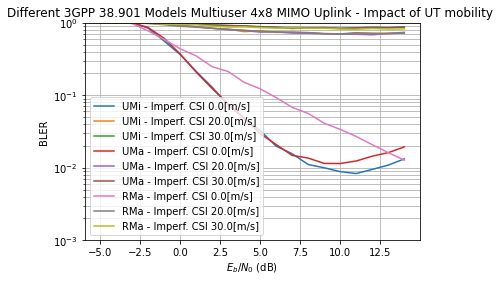

In [3]:
# Load results (uncomment to show saved results from the cell above)
#SIMS = eval("{'ebno_db': [-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0], 'scenario': ['umi', 'uma', 'rma'], 'perfect_csi': [True, False], 'ber': [[0.07905292510986328, 0.03808736801147461, 0.017681360244750977, 0.009239894087596606, 0.0050665537516276045, 0.0027629886053304755, 0.0016827532040175571, 0.0008500541736877042, 0.0004983015045593167, 0.00031632105509440104, 0.00018594996134440104, 0.00010455576578776041, 6.090927124023438e-05, 3.9520263671875e-05, 2.5684356689453124e-05, 1.4940897623697916e-05, 7.539113362630208e-06, 4.683176676432292e-06, 3.59344482421875e-06, 1.5436808268229167e-06, 7.578531901041666e-07], [0.29719797770182294, 0.26843706766764325, 0.2296581268310547, 0.17483605278862846, 0.10778331756591797, 0.07155566745334202, 0.04232830471462674, 0.022064606348673504, 0.015027618408203125, 0.008189432548754143, 0.005684130119554924, 0.00370962642928929, 0.002616008663393743, 0.0019156403011745876, 0.0015677095994417248, 0.0013081868489583333, 0.0010344430083840252, 0.0010432377567997685, 0.0009155009900555915, 0.0009102860117346291, 0.0008864811488560267], [0.06746260325113933, 0.0329127311706543, 0.014757650869864004, 0.007593437477394387, 0.003813561333550347, 0.0018911941496331237, 0.001028917273696588, 0.000513251788663255, 0.0002842496236165365, 0.00016032155354817708, 8.596547444661459e-05, 4.677454630533854e-05, 2.0359039306640624e-05, 1.1446634928385416e-05, 1.0133107503255209e-05, 3.92913818359375e-07, 1.682281494140625e-06, 6.421407063802083e-07, 1.3987223307291666e-08, 4.895528157552083e-07, 1.2715657552083333e-09], [0.2960662841796875, 0.2712268829345703, 0.2315998077392578, 0.17950481838650173, 0.11626561482747395, 0.0681504143608941, 0.04071949146412037, 0.02562223161969866, 0.014265790397738233, 0.009787991515591614, 0.006755871242947049, 0.004930473776424632, 0.003845776165569867, 0.003375189644949777, 0.0026965757616523173, 0.002434003298685431, 0.002402254330214634, 0.0021742226420969203, 0.0020746665425819925, 0.0021730139552350023, 0.0022606077648344492], [0.09145228068033855, 0.06702995300292969, 0.05034939448038737, 0.03308937766335227, 0.024936834971110027, 0.018199747258966618, 0.014243278974368249, 0.010329062478584155, 0.00815982288784451, 0.006009458884214744, 0.004231770833333333, 0.0033478243597622574, 0.0025576324126052015, 0.0019759736530521373, 0.0014438384618514623, 0.001123528113731971, 0.0008716690492438504, 0.0006736387408842243, 0.0004936694871486797, 0.00040878831294544955, 0.0002836583455403646], [0.2979132334391276, 0.2661628723144531, 0.22218640645345053, 0.1630952623155382, 0.11636797587076823, 0.08418807983398438, 0.06609598795572917, 0.047115184642650465, 0.035385449727376304, 0.026970704396565754, 0.02249379743609512, 0.016286409818209134, 0.011899021693638392, 0.008838085418051861, 0.007266274813948007, 0.005744590415610923, 0.0042660244551720895, 0.003129789240790991, 0.002527833716269651, 0.002067384265718006, 0.0014839694274598686]], 'bler': [[0.53173828125, 0.26806640625, 0.1279296875, 0.0637600806451613, 0.03380926724137931, 0.017422566371681415, 0.010500672043010752, 0.00547640931372549, 0.0030405569595645414, 0.001916015625, 0.0010703125, 0.00063671875, 0.00039453125, 0.000236328125, 0.000154296875, 9.1796875e-05, 6.25e-05, 3.515625e-05, 2.5390625e-05, 1.5625e-05, 1.171875e-05], [1.0, 1.0, 0.994140625, 0.86328125, 0.59619140625, 0.392578125, 0.2348090277777778, 0.127197265625, 0.081484375, 0.04469992897727273, 0.03009588068181818, 0.019152002427184466, 0.01331313775510204, 0.01019287109375, 0.008390893240343348, 0.00784375, 0.007462130248091603, 0.008697916666666666, 0.01016029792746114, 0.011945026676829269, 0.014048549107142858], [0.49609375, 0.25244140625, 0.10894097222222222, 0.05495876736111111, 0.026328125, 0.01235750786163522, 0.006649925595238095, 0.0034094621080139375, 0.001748046875, 0.0010078125, 0.000537109375, 0.000291015625, 0.000130859375, 9.1796875e-05, 6.0546875e-05, 9.765625e-06, 1.953125e-05, 1.3671875e-05, 5.859375e-06, 3.90625e-06, 1.953125e-06], [1.0, 1.0, 0.9951171875, 0.8912760416666666, 0.62353515625, 0.3834635416666667, 0.2265625, 0.14020647321428573, 0.07458043981481481, 0.050380608974358976, 0.03264973958333333, 0.023115808823529413, 0.017648507882882882, 0.015516493055555556, 0.013366284013605442, 0.013377568493150685, 0.015814012096774195, 0.017085597826086957, 0.0193958849009901, 0.02383753765060241, 0.02837611607142857], [0.5185546875, 0.3645833333333333, 0.267822265625, 0.17844460227272727, 0.128662109375, 0.09259588068181818, 0.07241030092592593, 0.05180921052631579, 0.041056315104166664, 0.030048076923076924, 0.021399456521739132, 0.016904633620689655, 0.013012210264900662, 0.01011981865284974, 0.007512019230769231, 0.0060276442307692305, 0.004715737951807229, 0.0035807291666666665, 0.0027969644134477824, 0.0022843567251461987, 0.001625], [1.0, 1.0, 0.9765625, 0.7649739583333334, 0.55517578125, 0.40625, 0.30747767857142855, 0.22200520833333334, 0.169921875, 0.1259765625, 0.10546875, 0.0751953125, 0.05613839285714286, 0.041555851063829786, 0.034078663793103446, 0.026551942567567568, 0.02025612113402062, 0.014954079198473283, 0.012090203220858896, 0.009994818239795918, 0.007302355410447761]], 'duration': 14960.869339227676}")

plt.figure()
plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BLER")
plt.grid(which="both")

i=0
legend = []
for scenario in MOBILITY_SIMS["scenario"]:
    for speed in MOBILITY_SIMS["speed"]:
        if scenario=="umi":
            t = "UMi"
        elif scenario=="uma":
            t = "UMa"
        else:
            t = "RMa"

        plt.semilogy(MOBILITY_SIMS["ebno_db"], MOBILITY_SIMS["bler"][i]);
        
        s = "{} - {} CSI {}[m/s]".format(t,"Imperf.", speed)
        legend.append(s)
        
        i += 1
        
plt.legend(legend)
plt.ylim([1e-3, 1])
plt.title("Different 3GPP 38.901 Models Multiuser 4x8 MIMO Uplink - Impact of UT mobility ");